In [0]:
# Taken and modified from https://github.com/cezar-lima/adanet_lab/blob/master/adanet_lab.ipynb

# CIFAR-10 dataset, classifying images with 10 categories.
!pip install adanet
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import adanet

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten


    100% |████████████████████████████████| 71kB 3.4MB/s 


In [0]:
# Load dataset
(x_train, labels_train), (x_test, labels_test) = tf.keras.datasets.cifar10.load_data()

print(f'x_train shape: {x_train.shape}')
print(f'labels_train shape: {labels_train.shape}')
print(f'x_test  shape: {x_test.shape}')
print(f'labels_test  shape: {labels_test.shape}')

170500096/170498071 [==============================] - 76s 0us/step
x_train shape: (50000, 32, 32, 3)
labels_train shape: (50000, 1)
x_test  shape: (10000, 32, 32, 3)
labels_test  shape: (10000, 1)


In [0]:
x_train = x_train / 255 # normalize data
x_test  = x_test / 255  # normalize data

x_train = x_train.astype(np.float32) # cast to float32
x_test = x_test.astype(np.float32)   # cast to float32

labels_train = labels_train.astype(np.int32) # cast to int32
labels_test = labels_test.astype(np.int32)   # cast to int32

In [0]:
TRAIN_SIZE = x_train.shape[0]
EPOCHS = 10
BATCH_SIZE=32
LEARNING_RATE = 0.001
print (TRAIN_SIZE)

50000


In [0]:
def show_images(rows=5, columns=5):
    """Prints a set of images."""

    for i in range(columns):
        for j in range(rows):
            index = j * columns + i + 1
            plt.subplot(rows, columns, index)
            plt.imshow(x_train[index-1])
    plt.show()

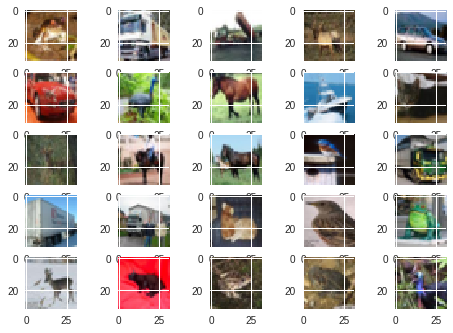

In [0]:
show_images()

In [0]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=labels_train,
    batch_size=BATCH_SIZE,
    num_epochs=EPOCHS,
    shuffle=True)

adanet_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=labels_train,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=labels_test,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False)

In [0]:
'''base model is a CNN (Convolutional Neural Network) with:

1 convolutional layer with 32 filters, kernel size equal to 7 and ReLU activation;
1 Max Pooling layer with reduction factor equal to 2;
1 flatten layer;
1 fully connected layer with 100 units and ReLU activation &
1 fully connected layer with 10 units and Softmax activation.'''



def cnn_model(features, labels, mode, params):
    images = list(features.values())[0] # get values from dict
    
    x = Conv2D(32, kernel_size=7, activation='relu')(images)
    x = MaxPooling2D(strides=2)(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    logits = Dense(10)(x)

    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Compute loss.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE, decay=0.0)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [0]:
classifier = tf.estimator.Estimator(model_fn=cnn_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpwcoo1j6s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b34f92ef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
MAX_STEPS = TRAIN_SIZE * EPOCHS // BATCH_SIZE

results, _ = tf.estimator.train_and_evaluate(
    classifier,
    train_spec=tf.estimator.TrainSpec(
        input_fn=train_input_fn,
        max_steps=MAX_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=test_input_fn,
        steps=None))

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpwcoo1j6s/model.ckpt.
INFO:tensorflow:loss = 2.2885923, step = 0
INFO:tensorflow:global_step/sec: 142.847
INFO:tensor

In [0]:
results

{'accuracy': 0.4163, 'global_step': 15625, 'loss': 4.5679207}

In [0]:
# base code: https://github.com/tensorflow/adanet/blob/master/adanet/examples/tutorials/customizing_adanet.ipynb

class CNNBuilder(adanet.subnetwork.Builder):
    def __init__(self, n_convs):
        self._n_convs = n_convs
                
    def build_subnetwork(self,
                         features,
                         logits_dimension,
                         training,
                         iteration_step,
                         summary,
                         previous_ensemble=None):
        """See `adanet.subnetwork.Builder`."""
        images = list(features.values())[0]
        x = images
        kernel_initializer = tf.keras.initializers.he_normal()
        
        x = tf.layers.conv2d(images, filters=32, kernel_size=7, padding="same",
                             activation="relu", kernel_initializer=kernel_initializer)
        x = tf.layers.max_pooling2d(x, pool_size=2, strides=2)
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x, units=64, activation="relu", kernel_initializer=kernel_initializer)
        
        # The `Head` passed to adanet.Estimator will apply the softmax activation.
        logits = tf.layers.dense(x, units=10, activation=None, kernel_initializer=kernel_initializer)
        
        
        
        complexity = tf.constant(self._n_convs + 1)

        persisted_tensors = {'n_convs': tf.constant(self._n_convs)}
        
        return adanet.Subnetwork(
            last_layer=x,
            logits=logits,
            complexity=complexity,
            persisted_tensors=persisted_tensors)
    
    def build_subnetwork_train_op(self,
                                subnetwork,
                                loss,
                                var_list,
                                labels,
                                iteration_step,
                                summary,
                                previous_ensemble=None):
        """See `adanet.subnetwork.Builder`."""

        optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE, decay=0.0)
        # NOTE: The `adanet.Estimator` increments the global step.
        return optimizer.minimize(loss=loss, var_list=var_list)

    def build_mixture_weights_train_op(self, loss, var_list, logits, labels,
                                     iteration_step, summary):
        """See `adanet.subnetwork.Builder`."""
        return tf.no_op("mixture_weights_train_op")

    @property
    def name(self):
        """See `adanet.subnetwork.Builder`."""
        if self._n_convs == 0:
            return 'dense'
        return f'cnn_{self._n_convs}'

In [0]:
class CNNGenerator(adanet.subnetwork.Generator):
    """Generates a `CNN` at each iteration.
    """

    def __init__(self):
        """Initializes a `Generator` that builds `SimpleCNNs`.

        Args:
          learning_rate: The float learning rate to use.
          max_iteration_steps: The number of steps per iteration.
          seed: The random seed.

        Returns:
          An instance of `Generator`.
        """
        self._cnn_builder_fn = CNNBuilder

    def generate_candidates(self, previous_ensemble, iteration_number,
                          previous_ensemble_reports, all_reports):
        """See `adanet.subnetwork.Generator`."""
        n_convs = 0
        if previous_ensemble:
            n_convs = tf.contrib.util.constant_value(
                previous_ensemble.weighted_subnetworks[-1]
                .subnetwork
                .persisted_tensors['n_convs'])

        return [
            self._cnn_builder_fn(n_convs=n_convs),
            self._cnn_builder_fn(n_convs=n_convs + 1)
        ]

In [0]:
N_CLASSES = 10
head = tf.contrib.estimator.multi_class_head(N_CLASSES)

In [0]:
ADANET_STEPS = 2
max_iteration_steps = MAX_STEPS // ADANET_STEPS

In [0]:
estimator = adanet.Estimator(
    head=head,
    subnetwork_generator=CNNGenerator(),
    max_iteration_steps=max_iteration_steps,
    evaluator=adanet.Evaluator(
        input_fn=adanet_input_fn,
        steps=None),
    adanet_loss_decay=.99)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4j7cjw1m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5aefa75898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
results, _ = tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=train_input_fn,
        max_steps=MAX_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=test_input_fn,
        steps=None))

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Beginning training AdaNet iteration 0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Building iteration 0
INFO:tensorflow:Building subnetwork 'dense'
INFO:tensorflow:Building subnetwork 'cnn_1'
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp4j7cjw1m/model.ckpt.
INFO:tensorflow:loss = 2.7189267, step = 0
INFO:tensorflow:global_step/sec: 73.022
INFO:tensorflow:loss = 2.0598776, step = 100 (1.376 sec)
INFO:tensorflow:global_st

In [0]:
def ensemble_architecture(result):
    """Extracts the ensemble architecture from evaluation results."""

    architecture = result["architecture/adanet/ensembles"]
    # The architecture is a serialized Summary proto for TensorBoard.
    summary_proto = tf.summary.Summary.FromString(architecture)
    return summary_proto.value[0].tensor.string_val[0]

In [0]:
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])
print(ensemble_architecture(results))

Accuracy: 0.452
Loss: 1.5856891
b'| cnn_1 | cnn_1 | cnn_2 |'
